In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import *
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from scipy import interp
from sklearn.metrics import roc_auc_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Set two decimal points for display
pd.options.display.float_format = "{:.2f}".format

# Load the Data

In [3]:
#Data saved in csv/excel
import glob, os

data_dir= "C:/Users/tsb7592/Box/ARMADA Operations/Data and Analysis/Mar 2021 UDS data (deidentified)"
os.chdir(data_dir)

In [4]:
uds= pd.read_csv("ARMADA_UDS_MAR21_DI.CSV")
uds.shape

(1046, 618)

In [5]:
import sys 

stdoutOrigin=sys.stdout 
sys.stdout = open("C:/Users/tsb7592/Box/ARMADA Operations/Data and Analysis/stat_output.txt", "w")

In [4]:
armada= pd.read_csv("C:/Users/tsb7592/Box/ARMADA Operations/Data and Analysis/May 2020 Interim Analysis Data for Manuscripts/ARMADA_TBSCORES_MAY2020.csv")
armada.shape

(1083, 189)

In [5]:
armada.head()

,ptid,assmnt,site,cohort2,LANGUAGE,AGE,gender_rc,ethnicity_rc,race_tb_rc,racetb_w,...,VisualAc_FCTScore,VisualAc_Raw,VisualAc_svalogmar,VisualAc_svasnellen,VisualAc_UCSScore,WIN_Raw_L,WIN_Raw_R,WIN_Thresh_L,WIN_Thresh_R,race_summary
0,1.45635,1,Emory,6,en-US,82,2,1,2,0,...,60.00,82.00,-0.04,20/16-3,95.00,20.00,18.00,10.00,11.60,2
1,1.46421,1,Emory,4,en-US,88,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1.46421,2,Emory,4,en-US,89,1,1,1,1,...,NaN,76.00,0.08,20/20-4,82.00,0.00,0.00,26.00,26.00,1
3,1.46422,1,Emory,3,en-US,88,2,1,1,1,...,NaN,70.00,0.20,20/30,70.00,7.00,9.00,20.40,18.80,1
4,1.46422,2,Emory,3,en-US,89,2,1,1,1,...,NaN,77.00,0.06,20/20-3,84.00,5.00,8.00,22.00,19.60,1


In [6]:
cohort ={1:"Gen population healthy aging 85+", 2:"Gen population 65-85", 3:"Gen population MCI",
4:"Gen population AD", 5:"African American mild cognitive impairment",
6:"African American normal controls 65-85", 7:"Spanish Speaking mild cognitive impairment",
8:"Spanish Speaking normal controls 65-85", 9:"Spanish Speaking AD"}

In [7]:
#Rename the value under column cohort2
armada['cohort2'] = armada['cohort2'].map(cohort)

# Data Cleaning

In [8]:
#Combine ARMADA with this UDS left join
df = pd.merge(armada,uds, how="left", on=['ptid','assmnt'])

In [9]:
df.head()

,ptid,assmnt,site,cohort2,LANGUAGE,AGE,gender_rc,ethnicity_rc,race_tb_rc,racetb_w,...,RESPHEAR,RESPDIST,RESPINTR,RESPDISN,RESPFATG,RESPEMOT,RESPASST,RESPOTH,RESPOTHX,NACCMOCB
0,1.45635,1,Emory,6,en-US,82,2,1,2,0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0
1,1.46421,1,Emory,4,en-US,88,1,1,1,1,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0
2,1.46421,2,Emory,4,en-US,89,1,1,1,1,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0
3,1.46422,1,Emory,3,en-US,88,2,1,1,1,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0
4,1.46422,2,Emory,3,en-US,89,2,1,1,1,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0


In [10]:
#Only keep the rows with a valid MINDATEDIFF
df =df[df.MINDATEDIFF.notnull()]

In [11]:
df.shape

(1046, 805)

In [12]:
#MEMORY through comport (so total of 10 variables)
keep = ['MEMORY', 'ORIENT', 'JUDGMENT', 'COMMUN', 'HOMEHOBB', 'PERSCARE',
       'CDRSUM', 'CDRGLOB', 'COMPORT']

In [13]:
df.columns

Index(['ptid', 'assmnt', 'site', 'cohort2', 'LANGUAGE', 'AGE', 'gender_rc',
       'ethnicity_rc', 'race_tb_rc', 'racetb_w',
       ...
       'RESPHEAR', 'RESPDIST', 'RESPINTR', 'RESPDISN', 'RESPFATG', 'RESPEMOT',
       'RESPASST', 'RESPOTH', 'RESPOTHX', 'NACCMOCB'],
      dtype='object', length=805)

In [14]:
df[keep]

,MEMORY,ORIENT,JUDGMENT,COMMUN,HOMEHOBB,PERSCARE,CDRSUM,CDRGLOB,COMPORT
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.5,1.0,1.0,1.0,1.0,5.5,1.0,0.0
2,2.0,1.0,2.0,2.0,2.0,2.0,11.0,2.0,1.0
3,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0
4,0.5,0.5,0.5,0.0,0.0,0.0,1.5,0.5,0.0
...,...,...,...,...,...,...,...,...,...
1078,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN
1079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1081,0.5,0.0,0.0,0.0,0.0,0.0,NaN,0.5,NaN


In [15]:
df.head()

,ptid,assmnt,site,cohort2,LANGUAGE,AGE,gender_rc,ethnicity_rc,race_tb_rc,racetb_w,...,RESPHEAR,RESPDIST,RESPINTR,RESPDISN,RESPFATG,RESPEMOT,RESPASST,RESPOTH,RESPOTHX,NACCMOCB
0,1.45635,1,Emory,6,en-US,82,2,1,2,0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0
1,1.46421,1,Emory,4,en-US,88,1,1,1,1,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0
2,1.46421,2,Emory,4,en-US,89,1,1,1,1,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0
3,1.46422,1,Emory,3,en-US,88,2,1,1,1,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0
4,1.46422,2,Emory,3,en-US,89,2,1,1,1,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0


In [18]:
df.cohort2.value_counts()

Gen population 65-85                          265
Gen population healthy aging 85+              134
Gen population MCI                            133
African American normal controls 65-85        127
Spanish Speaking normal controls 65-85        126
Spanish Speaking mild cognitive impairment    112
Gen population AD                              83
African American mild cognitive impairment     42
Spanish Speaking AD                            24
Name: cohort2, dtype: int64

In [19]:
select = [ 'Gen population 65-85', 'Gen population MCI','Gen population AD']
genpop = df[df.cohort2.isin(select)]

In [20]:
genpop[keep]

,MEMORY,ORIENT,JUDGMENT,COMMUN,HOMEHOBB,PERSCARE,CDRSUM,CDRGLOB,COMPORT
1,1.0,0.5,1.0,1.0,1.0,1.0,5.5,1.0,0.0
2,2.0,1.0,2.0,2.0,2.0,2.0,11.0,2.0,1.0
3,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0
4,0.5,0.5,0.5,0.0,0.0,0.0,1.5,0.5,0.0
6,1.0,0.0,0.0,0.0,0.5,0.0,1.5,0.5,0.0
...,...,...,...,...,...,...,...,...,...
840,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0
946,0.5,0.0,0.0,0.0,0.0,0.0,NaN,0.5,NaN
974,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.5,NaN
991,0.5,0.0,0.5,0.5,0.5,0.0,NaN,0.5,NaN


# 1) Count for each variable across all 3 gen pop groups 

In [21]:
counts  = genpop.groupby('cohort2')[keep].count().unstack().reset_index().pivot(index='level_0', columns='cohort2', values=0)

In [22]:
counts =counts.reindex(keep)[select]
print(counts)

# 2) ANOVA & Tukey’s Test

https://www.statology.org/tukey-test-python/

In [23]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

#The one-way ANOVA tests the null hypothesis that 3 genpop groups have the same population mean.
print("----one-way ANOVA----")
print(f_oneway(counts.iloc[:,0],counts.iloc[:,1],counts.iloc[:,2]))

F_onewayResult(statistic=200.69804129168858, pvalue=1.039951452532637e-15)

In [24]:
df.tail()

,ptid,assmnt,site,cohort2,LANGUAGE,AGE,gender_rc,ethnicity_rc,race_tb_rc,racetb_w,...,RESPHEAR,RESPDIST,RESPINTR,RESPDISN,RESPFATG,RESPEMOT,RESPASST,RESPOTH,RESPOTHX,NACCMOCB
0,1.45635,1,Emory,African American normal controls 65-85,en-US,82,2,1,2,0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0
1,1.46421,1,Emory,Gen population AD,en-US,88,1,1,1,1,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0
2,1.46421,2,Emory,Gen population AD,en-US,89,1,1,1,1,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0
3,1.46422,1,Emory,Gen population MCI,en-US,88,2,1,1,1,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0
4,1.46422,2,Emory,Gen population MCI,en-US,89,2,1,1,1,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1078,X20106,1,CU,Spanish Speaking normal controls 65-85,es,68,1,2,32,0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,NaN
1079,X20115,1,CU,Spanish Speaking normal controls 65-85,es,70,1,2,32,0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,NaN
1080,X20116,1,CU,Spanish Speaking mild cognitive impairment,es,66,1,2,32,0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,NaN
1081,X20119,1,CU,Spanish Speaking mild cognitive impairment,es,76,1,2,32,0,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,NaN


In [26]:
counts

cohort2,Gen population 65-85,Gen population MCI,Gen population AD
level_0,,,
MEMORY,265,132,83
ORIENT,265,132,83
JUDGMENT,265,132,83
COMMUN,265,132,83
HOMEHOBB,265,132,83
PERSCARE,265,132,83
CDRSUM,265,128,83
CDRGLOB,265,132,83
COMPORT,168,127,83


In [25]:
cdf = pd.DataFrame({'score': [265, 265, 265, 265, 265, 265, 265, 265, 168,
                             132, 132, 132, 132, 132, 132, 128, 132, 127,
                             83, 83, 83, 83, 83, 83, 83, 83, 83],
                   'group': np.repeat(['Gen population 65-85', 'Gen population MCI', 'Gen population AD'], repeats=9)}) 

In [27]:
cdf

,score,group
0,265,Gen population 65-85
1,265,Gen population 65-85
2,265,Gen population 65-85
3,265,Gen population 65-85
4,265,Gen population 65-85
5,265,Gen population 65-85
6,265,Gen population 65-85
7,265,Gen population 65-85
8,168,Gen population 65-85
9,132,Gen population MCI


In [28]:
# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=cdf['score'],
                          groups=cdf['group'],
                          alpha=0.05)

#display results
print(tukey)

# 3)  NACCFAM counts per group

In [29]:
df.NACCFAM.value_counts()

9.0    546
1.0    314
0.0    186
Name: NACCFAM, dtype: int64

In [30]:
#Drop the unknown NACCFAM 
Ncounts  = genpop[genpop.NACCFAM !=9 ].groupby('NACCFAM')['cohort2'].value_counts().unstack()
#Ncounts.to_excel('C:/Users/tsb7592/Downloads/NACCFAM.xlsx')

In [31]:
print(Ncounts)

In [32]:
#Chi square results got from R

#Pearson's Chi-squared test
print('X-squared = 7.7844, df = 2, p-value = 0.0204')
print("")

# 4) HYPERT counts per group

In [33]:
df.HYPERTEN.unique()

array([ 1., -4.,  0.,  2.,  9.])

In [34]:
df.HYPERCHO.value_counts()

-4.0    463
 1.0    288
 0.0    282
 2.0     12
 9.0      1
Name: HYPERCHO, dtype: int64

In [35]:
h1=genpop[(genpop.HYPERTEN != 9 )&(genpop.HYPERTEN !=-4)].groupby('HYPERTEN')['cohort2'].value_counts().unstack().fillna(0)
print(h1)

In [36]:
#Pearson's Chi-squared test

data:  h1
print("X-squared = 15.884, df = 4, p-value = 0.003179")
print("")

In [37]:
h2=genpop[(genpop.HYPERCHO != 9 )&(genpop.HYPERCHO !=-4)].groupby('HYPERCHO')['cohort2'].value_counts().unstack().fillna(0)
print(h2)

In [38]:
#Pearson's Chi-squared test

#data:  h2
print("X-squared = 7.0551, df = 4, p-value = 0.133")


In [39]:
sys.stdout.close()
sys.stdout=stdoutOrigin

# Armada Pain
For each of the four Odor variables:
Compare them by cohort (so there should be nine in total)

In [8]:
Odor =[]
for val in armada.columns:
    if 'Odor' in val:
        Odor.append(val)
    if 'Pain' in val:
        print(val)

PainInt_Raw
PainInt_SE
PainInt_Theta
PainInt_TScore


In [10]:
armada.cohort2.unique()

array(['African American normal controls 65-85', 'Gen population AD',
       'Gen population MCI', 'African American mild cognitive impairment',
       'Gen population 65-85', 'Gen population healthy aging 85+',
       'Spanish Speaking mild cognitive impairment',
       'Spanish Speaking normal controls 65-85', 'Spanish Speaking AD'],
      dtype=object)

In [11]:
odor = armada.groupby('cohort2')[Odor].count().unstack().reset_index().pivot(index='level_0', columns='cohort2', values=0)
odor

cohort2,African American mild cognitive impairment,African American normal controls 65-85,Gen population 65-85,Gen population AD,Gen population MCI,Gen population healthy aging 85+,Spanish Speaking AD,Spanish Speaking mild cognitive impairment,Spanish Speaking normal controls 65-85
level_0,,,,,,,,,
Odor_ACSScore,42,127,264,72,112,17,21,108,125
Odor_FCTScore,41,127,264,72,112,17,21,108,123
Odor_Raw,43,127,264,79,137,132,24,113,125
Odor_UCSScore,43,127,264,79,137,132,24,113,125


# Histogram (9)
Boxplot (nine boxplots)
Table with Ns, Min, Median, Mean, Max, and SD
One row for all data
Nine rows for each of the cohorts
Table of 10 x 6

In [9]:
Odor

['Odor_ACSScore', 'Odor_FCTScore', 'Odor_Raw', 'Odor_UCSScore']

<Figure size 576x432 with 0 Axes>

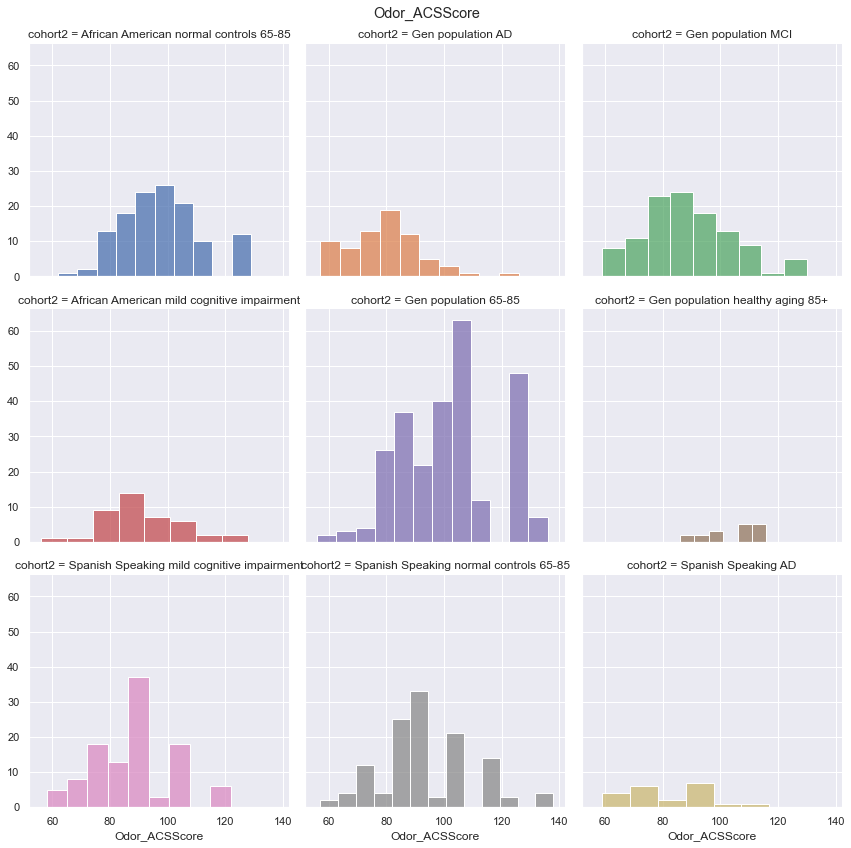

<Figure size 576x432 with 0 Axes>

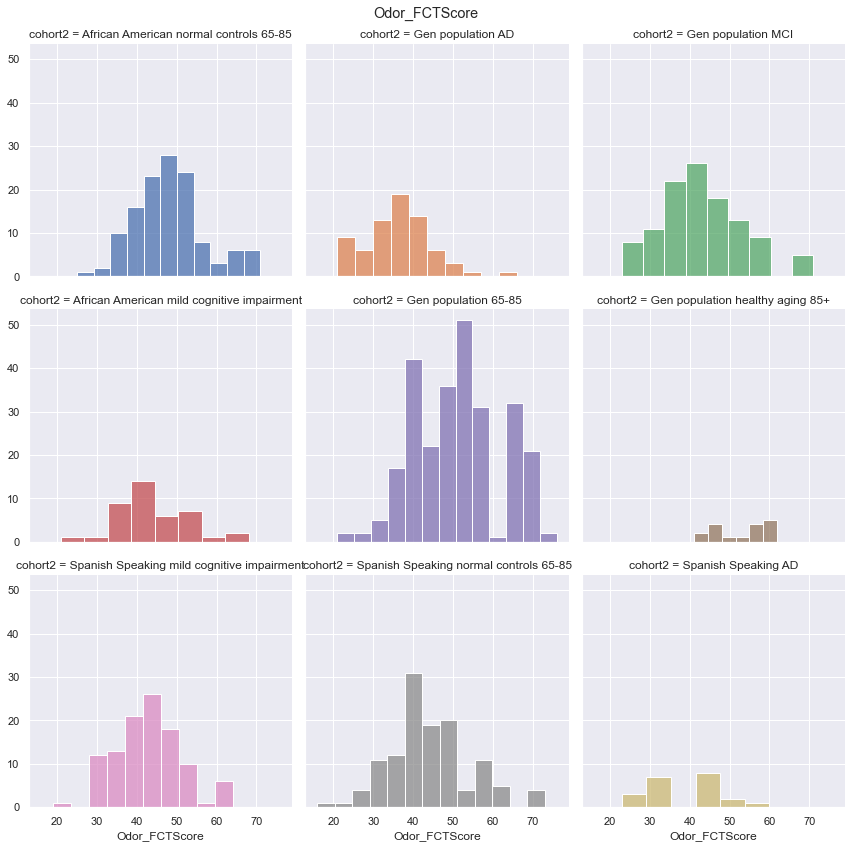

<Figure size 576x432 with 0 Axes>

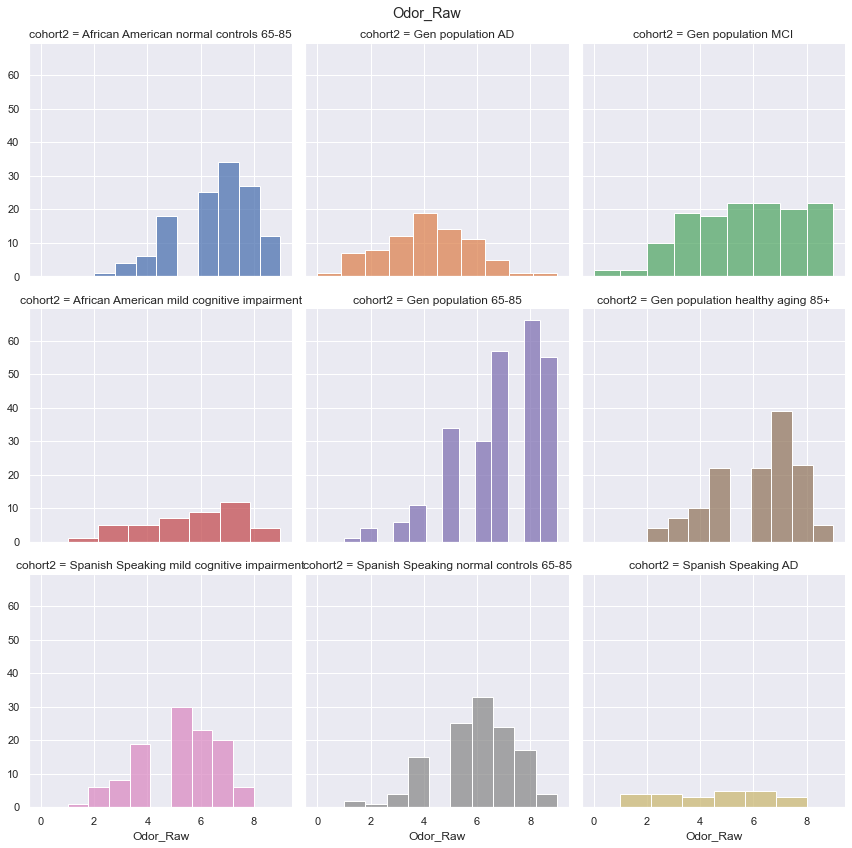

<Figure size 576x432 with 0 Axes>

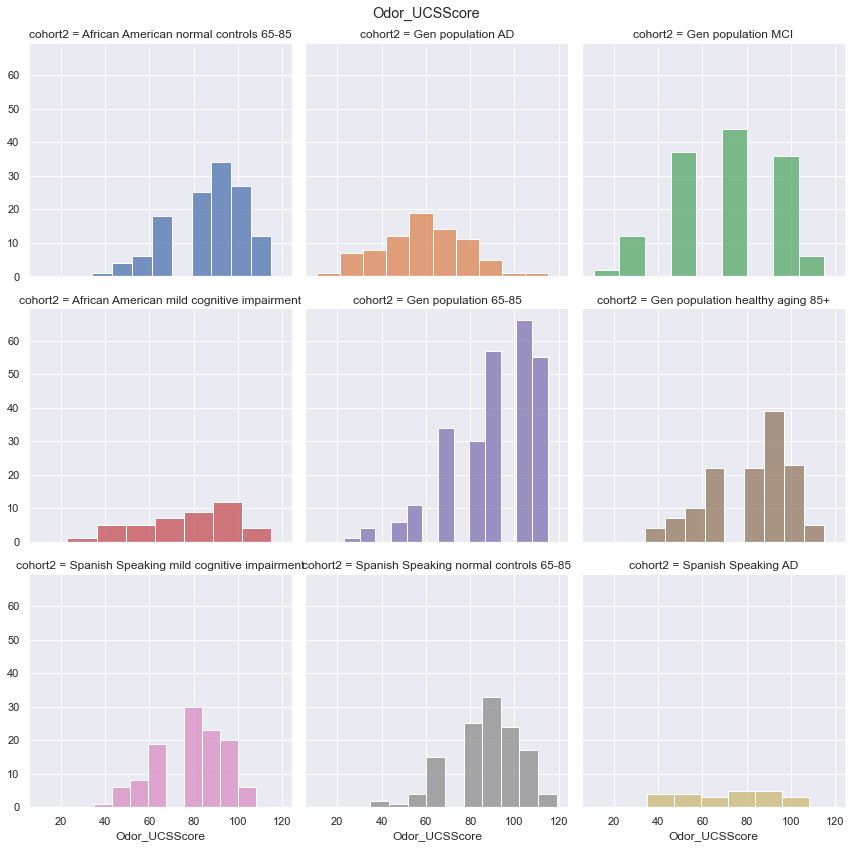

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

for var in Odor:
    sns.set() 
    plt.figure(figsize=(8, 6))
    g = sns.FacetGrid(armada, col="cohort2" ,hue="cohort2",size=4, aspect=1,col_wrap=3)
    g.fig.suptitle(var)
    g.map(sns.histplot, var)
    plt.savefig(str(var)+'_hist.png')

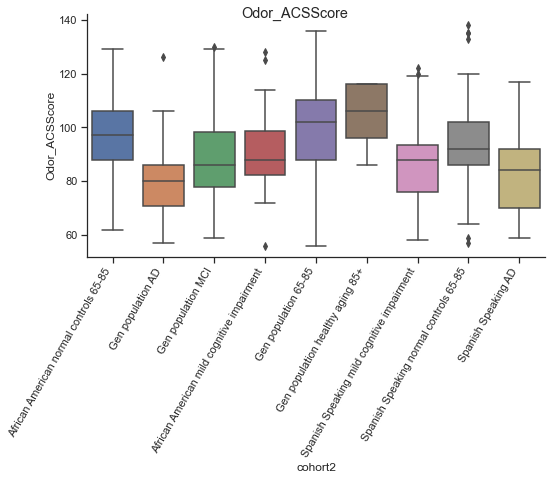

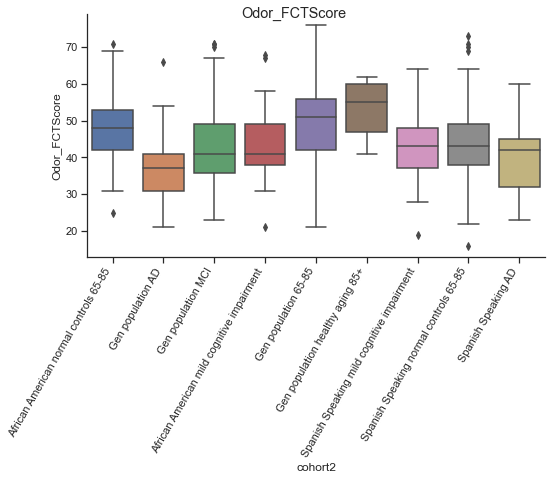

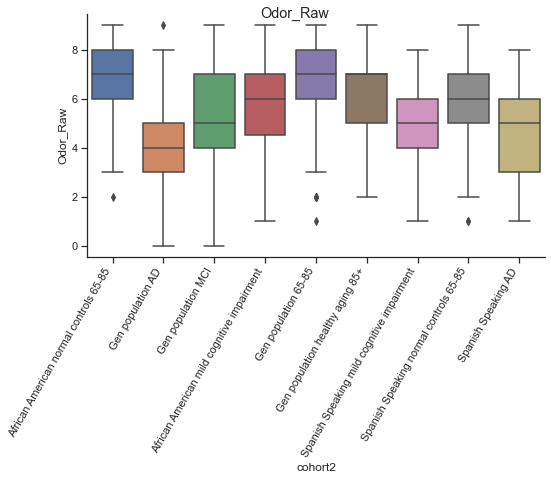

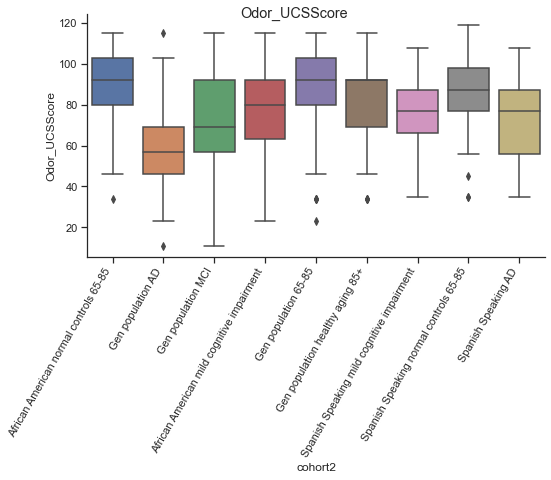

In [52]:
sns.set_style('ticks')
for var in Odor:
    g = sns.factorplot('cohort2', var,  data=armada, kind="box",  size=4, aspect=2)
    g.fig.suptitle(var)
    
    for axes in g.axes.flat:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=60, horizontalalignment='right')
    
    plt.savefig(str(var)+'_boxplot.png')

In [35]:
#Data saved in csv/excel
import glob, os

data_dir= "C:/Users/tsb7592/Box/ARMADA Operations/Data and Analysis"
os.chdir(data_dir)

In [48]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('C:/Users/tsb7592/Box/ARMADA Operations/Data and Analysis/odor_tables.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
odor.to_excel(writer, sheet_name='by_cohort')

for var in Odor:
    table =armada.groupby('cohort2')[var].describe().unstack().reset_index().pivot(index='level_0', columns='cohort2', values=0)
    table.iloc[[1,3,4,5,6,7],:].to_excel(writer, sheet_name=var)
    display(table)
# Close the Pandas Excel writer and output the Excel file.
writer.save()

cohort2,African American mild cognitive impairment,African American normal controls 65-85,Gen population 65-85,Gen population AD,Gen population MCI,Gen population healthy aging 85+,Spanish Speaking AD,Spanish Speaking mild cognitive impairment,Spanish Speaking normal controls 65-85
level_0,,,,,,,,,
25%,82.25,88.00,88.00,70.75,77.75,96.00,70.00,76.00,86.00
50%,88.00,97.00,102.00,80.00,86.00,106.00,84.00,88.00,92.00
75%,98.75,106.00,110.00,86.00,98.25,116.00,92.00,93.25,102.00
count,42.00,127.00,264.00,72.00,112.00,17.00,21.00,108.00,125.00
max,128.00,129.00,136.00,126.00,130.00,116.00,117.00,122.00,138.00
mean,90.36,97.69,101.79,79.03,88.80,103.06,81.48,88.25,93.95
min,56.00,62.00,56.00,57.00,59.00,86.00,59.00,58.00,57.00
std,13.97,13.81,16.79,13.08,15.92,10.91,15.14,13.53,15.94


cohort2,African American mild cognitive impairment,African American normal controls 65-85,Gen population 65-85,Gen population AD,Gen population MCI,Gen population healthy aging 85+,Spanish Speaking AD,Spanish Speaking mild cognitive impairment,Spanish Speaking normal controls 65-85
level_0,,,,,,,,,
25%,38.00,42.00,42.00,30.75,35.75,47.00,32.00,37.00,38.00
50%,41.00,48.00,51.00,37.00,41.00,55.00,42.00,43.00,43.00
75%,49.00,53.00,56.00,41.00,49.00,60.00,45.00,48.00,49.00
count,41.00,127.00,264.00,72.00,112.00,17.00,21.00,108.00,123.00
max,68.00,71.00,76.00,66.00,71.00,62.00,60.00,64.00,73.00
mean,43.59,48.25,51.00,36.24,42.71,52.41,38.57,42.61,44.20
min,21.00,25.00,21.00,21.00,23.00,41.00,23.00,19.00,16.00
std,9.20,8.87,10.89,8.51,10.54,6.97,9.76,8.37,10.27


cohort2,African American mild cognitive impairment,African American normal controls 65-85,Gen population 65-85,Gen population AD,Gen population MCI,Gen population healthy aging 85+,Spanish Speaking AD,Spanish Speaking mild cognitive impairment,Spanish Speaking normal controls 65-85
level_0,,,,,,,,,
25%,4.50,6.00,6.00,3.00,4.00,5.00,3.00,4.00,5.00
50%,6.00,7.00,7.00,4.00,5.00,7.00,5.00,5.00,6.00
75%,7.00,8.00,8.00,5.00,7.00,7.00,6.00,6.00,7.00
count,43.00,127.00,264.00,79.00,137.00,132.00,24.00,113.00,125.00
max,9.00,9.00,9.00,9.00,9.00,9.00,8.00,8.00,9.00
mean,5.65,6.61,6.98,4.09,5.22,6.16,4.50,5.21,5.91
min,1.00,2.00,1.00,0.00,0.00,2.00,1.00,1.00,1.00
std,1.76,1.53,1.73,1.85,2.10,1.66,1.98,1.56,1.59


cohort2,African American mild cognitive impairment,African American normal controls 65-85,Gen population 65-85,Gen population AD,Gen population MCI,Gen population healthy aging 85+,Spanish Speaking AD,Spanish Speaking mild cognitive impairment,Spanish Speaking normal controls 65-85
level_0,,,,,,,,,
25%,63.00,80.00,80.00,46.00,57.00,69.00,56.00,66.00,77.00
50%,80.00,92.00,92.00,57.00,69.00,92.00,77.00,77.00,87.00
75%,92.00,103.00,103.00,69.00,92.00,92.00,87.00,87.00,98.00
count,43.00,127.00,264.00,79.00,137.00,132.00,24.00,113.00,125.00
max,115.00,115.00,115.00,115.00,115.00,115.00,108.00,108.00,119.00
mean,76.30,87.33,91.57,58.27,71.27,82.11,71.50,78.99,86.31
min,23.00,34.00,23.00,11.00,11.00,34.00,35.00,35.00,35.00
std,20.22,17.63,19.86,21.25,24.19,19.11,20.68,16.41,16.70


In [49]:
Odor

['Odor_ACSScore', 'Odor_FCTScore', 'Odor_Raw', 'Odor_UCSScore']